In [1]:
import pandas as pd
import numpy as np
import time
import gc
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from s3fs.core import S3FileSystem
from tqdm import tqdm

def draw_screen_poly(lats, lons, map):
    x, y = map( lons, lats )
    xy = zip(x,y)
    poly = Polygon(list(xy), 
                   edgecolor="black",
                   facecolor="None",
                   lw=2.5)
    plt.gca().add_patch(poly)

def global_map_plot(df, variable, vmin, vmax, cmap, title):
    # get new coordinate
    df["lon_new"] = np.where(df['lon'] <= 180, df['lon'], df['lon']-360)
        # Midwest US
    # https://en.wikipedia.org/wiki/Module:Location_map/data/USA_Midwest
    lats_mw_us = [ 36.15, 49.5, 49.5, 36.15 ]
    lons_mw_us = [ -95, -95, -75, -75 ]

    # Europe
    lats_eu = [ 40, 50, 50, 40 ]
    lons_eu = [ 15, 15, 30, 30 ]

    # India https://link.springer.com/article/10.1007/s12524-011-0119-x
    # Just say central India and the indo gangetic plains 
    lats_in = [ 18, 25, 25, 18 ]
    lons_in = [ 75, 75, 87, 87 ]

    # https://baike.baidu.com/item/%E5%8D%8E%E5%8C%97%E5%B9%B3%E5%8E%9F
    lats_ch = [ 32, 45, 45, 32 ]
    lons_ch = [ 110, 110, 123, 123 ]
    
    
    plt.figure(figsize=(16, 7))
    map = Basemap()
    map.drawcoastlines()
    map.drawcoastlines()
    map.readshapefile('../../5_event_analysis/shapefile/maps', 'maps')
    map.drawmeridians(range(0, 360, 30),labels=[True,False,False,True],fontsize=20)
    map.drawparallels(range(-90, 100, 30), labels=[True,False,False,True],fontsize=20)
    draw_screen_poly(lats_mw_us, lons_mw_us, map)
    draw_screen_poly(lats_eu, lons_eu, map)
    draw_screen_poly(lats_in, lons_in, map)
    draw_screen_poly(lats_ch, lons_ch, map)
    
    if cmap == "bwr":
        map.fillcontinents(zorder=0)
    plt.scatter(df["lon_new"], df["lat"], 
                c=df[variable],
                s=6, cmap=cmap, vmin=vmin, vmax=vmax)
    clb = plt.colorbar(orientation="vertical",fraction = 0.023, pad=0.01)
    clb.ax.tick_params(labelsize=20)
    #plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1)
    #plt.savefig("./"+title+"_rmse.pdf")
    plt.show()

## Save the necessary files

In [2]:
%%time

s3 = S3FileSystem()
validation_path = "/data/keeling/a/zzheng25/b/UrbanHWs/CESM_validation/"
save_dir = "S3://uhws/UHWs_CESM/model-validation-diff/"
rmse_by_lat_lon_ls = []

for i in tqdm(range(2,34)):
        member = (str(i).zfill(3))
        #print("member:",member)

        df_2006=pd.read_csv("/data/keeling/a/zzheng25/b/UrbanHWs/CESM_validation/2006/033_ens.csv")
        rmse_by_lat_lon_2006 = df_2006.groupby(["lat","lon"])\
                                   .apply(lambda df_2006: 
                                          np.mean(df_2006["033"]-df_2006["TREFMXAV_U"]))

        df_2061=pd.read_csv("/data/keeling/a/zzheng25/b/UrbanHWs/CESM_validation/2061/033_ens.csv")
        rmse_by_lat_lon_2061 = df_2061.groupby(["lat","lon"])\
                                   .apply(lambda df_2061: 
                                          np.mean(df_2061["033"]-df_2061["TREFMXAV_U"]))
        
        rmse_by_lat_lon_ls.append(rmse_by_lat_lon_2061 - rmse_by_lat_lon_2006)
        
        del df_2006, df_2061, rmse_by_lat_lon_2006, rmse_by_lat_lon_2061
        gc.collect()
        
rmse_by_lat_lon=pd.concat(rmse_by_lat_lon_ls,axis=1)
rmse_by_lat_lon.to_csv(save_dir+"rmse_by_lat_lon.csv")

100%|██████████| 32/32 [15:55<00:00, 29.87s/it]


CPU times: user 14min 32s, sys: 1min 23s, total: 15min 55s
Wall time: 15min 57s


## visualization

In [2]:
s3 = S3FileSystem()
validation_path = "/data/keeling/a/zzheng25/b/UrbanHWs/CESM_validation/"
save_dir = "S3://uhws/UHWs_CESM/model-validation-diff/"
df = pd.read_csv(save_dir+"rmse_by_lat_lon.csv")
df_mean = df.set_index(["lat","lon"]).mean(axis=1)

,lat,lon,0,1,2,3,4,5,6,7,...,22,23,24,25,26,27,28,29,30,31
count,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,...,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000,4439.000000
mean,23.864969,131.385729,-0.002851,-0.002851,-0.002851,-0.002851,-0.002851,-0.002851,-0.002851,-0.002851,...,-0.002851,-0.002851,-0.002851,-0.002851,-0.002851,-0.002851,-0.002851,-0.002851,-0.002851,-0.002851
std,25.646228,111.895429,0.075527,0.075527,0.075527,0.075527,0.075527,0.075527,0.075527,0.075527,...,0.075527,0.075527,0.075527,0.075527,0.075527,0.075527,0.075527,0.075527,0.075527,0.075527
min,-54.188499,0.000000,-0.726405,-0.726405,-0.726405,-0.726405,-0.726405,-0.726405,-0.726405,-0.726405,...,-0.726405,-0.726405,-0.726405,-0.726405,-0.726405,-0.726405,-0.726405,-0.726405,-0.726405,-0.726405
25%,8.952900,36.250000,-0.037195,-0.037195,-0.037195,-0.037195,-0.037195,-0.037195,-0.037195,-0.037195,...,-0.037195,-0.037195,-0.037195,-0.037195,-0.037195,-0.037195,-0.037195,-0.037195,-0.037195,-0.037195
50%,29.685900,100.000000,-0.003528,-0.003528,-0.003528,-0.003528,-0.003528,-0.003528,-0.003528,-0.003528,...,-0.003528,-0.003528,-0.003528,-0.003528,-0.003528,-0.003528,-0.003528,-0.003528,-0.003528,-0.003528
75%,42.879601,260.000000,0.032497,0.032497,0.032497,0.032497,0.032497,0.032497,0.032497,0.032497,...,0.032497,0.032497,0.032497,0.032497,0.032497,0.032497,0.032497,0.032497,0.032497,0.032497
max,70.209396,358.750000,0.381778,0.381778,0.381778,0.381778,0.381778,0.381778,0.381778,0.381778,...,0.381778,0.381778,0.381778,0.381778,0.381778,0.381778,0.381778,0.381778,0.381778,0.381778


count    4439.000000
mean       -0.002851
std         0.075527
min        -0.726405
25%        -0.037195
50%        -0.003528
75%         0.032497
max         0.381778
dtype: float64

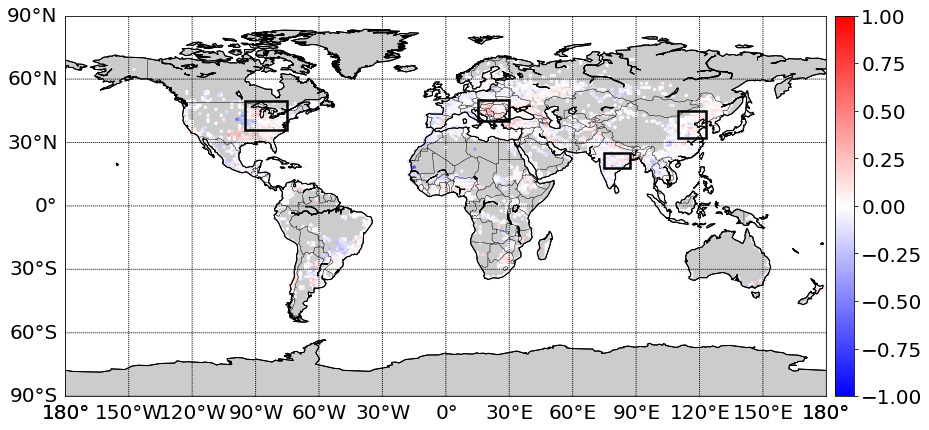

In [3]:
display(df.describe())
display(df_mean.describe())
global_map_plot(df_mean.reset_index(), 0, -1, 1, "bwr","")